In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("ENB2012_data.csv")
print(f'Размер данных: {data.shape}')

Размер данных: (768, 10)


Описание датасета:  
Ссылка на датасет на kaggle: https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset  

Предметная область: Архитектура и энергоэффективность зданий  
Датасет создан: Angeliki Xifara (инженер-строитель)  
Обработан: Athanasios Tsanas (Оксфордский университет)  
Характер данных: иммитационные  

Артибуты датасета: 8 признаков и 2 целевые переменные.  
X1 Relative Compactness - Относительная компактность (decimal, непрерывный)  
X2 Surface Area - Площадь поверхности (decimal, непрерывный)  
X3 Wall Area - Площадь стен (decimal, непрерывный)  
X4 Roof Area - Площадь крыши (decimal, непрерывный)  
X5 Overall Height - Общая высота (decimal, непрерывный)  
X6 Orientation - Ориентация. 2 = Север, 3 = Восток, 4 = Юг, 5 = Запад. (int, категориальный)  
X7 Glazing Area - Площадь остекления (decimal, непрерывный)  
X8 Glazing Area Distribution - Распределение площади остекления. 0 = Без окон, 1 = Равномерное распределение по всем фасадам, 2, 3, 4, 5 = Преимущественно на северной, восточной, южной, западной стороне (int, категориальный)  
y1 Heating Load - Тепловая нагрузка на отопление (decimal, непрерывный)  
y2 Cooling Load - Тепловая нагрузка на охлаждение (decimal, непрерывный)  

Задача анализа: Прогнозирование энергетической нагрузки на отопление и охлаждение зданий на основе их архитектурных параметров.

In [4]:
data.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'y1', 'y2']
stats_list = []
for col in data.columns:
    stats_list.append({
        'Атрибут': col,
        'Среднее': data[col].mean(),
        'СКО': data[col].std(),
        'Пропуски': data[col].isnull().sum()
    })

stats_df = pd.DataFrame(stats_list)
print(stats_df.round(3))

  Атрибут  Среднее     СКО  Пропуски
0      X1    0.764   0.106         0
1      X2  671.708  88.086         0
2      X3  318.500  43.626         0
3      X4  176.604  45.166         0
4      X5    5.250   1.751         0
5      X6    3.500   1.119         0
6      X7    0.234   0.133         0
7      X8    2.812   1.551         0
8      y1   22.307  10.090         0
9      y2   24.588   9.513         0


Пропусков нет

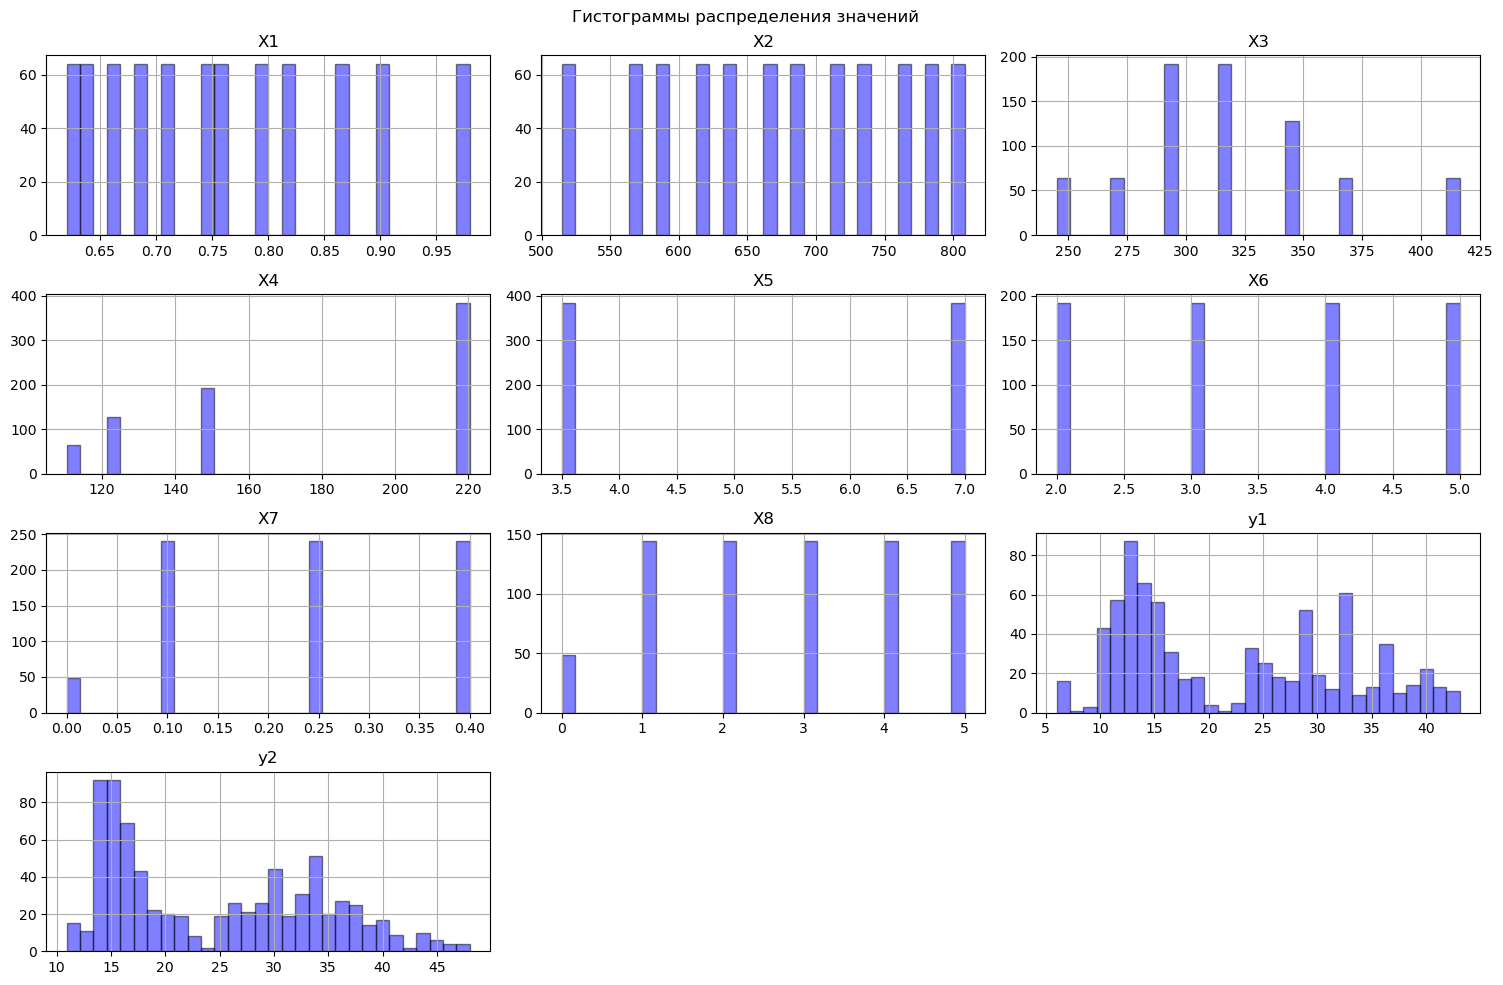

In [8]:
# Построение гистограмм
data[data.columns].hist(bins=30, figsize=(15, 10), color='blue', edgecolor='black', alpha=0.5)
plt.suptitle('Гистограммы распределения значений')
plt.tight_layout()
plt.show()

In [12]:
# Анализ выбросов
print("Выбросы:")
for col in data.columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)]
    print(col + ":", len(outliers))

Выбросы:
X1: 0
X2: 0
X3: 0
X4: 0
X5: 0
X6: 0
X7: 0
X8: 0
y1: 0
y2: 0


Выбросов нет

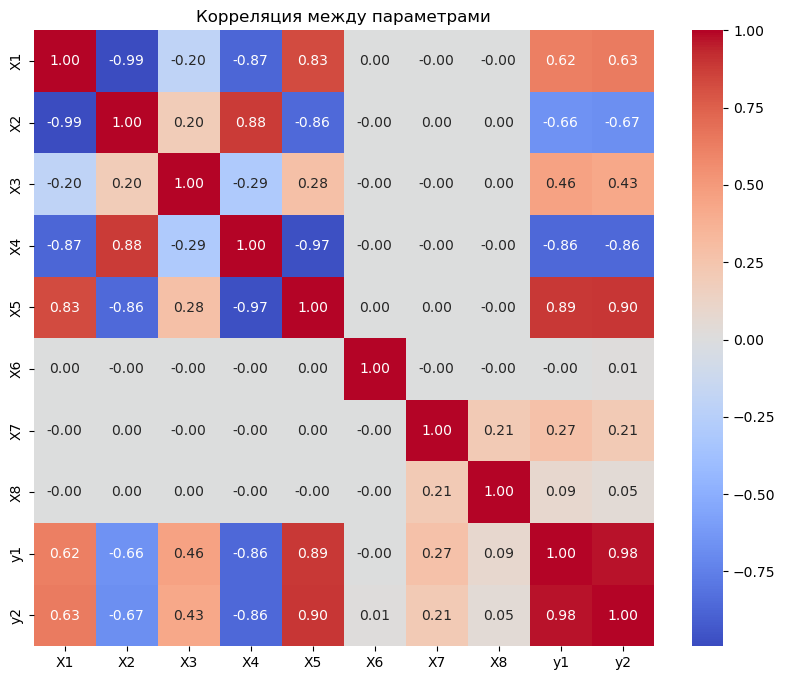

In [13]:
# Определяем корреляцию между параметрами
corr_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между параметрами')
plt.show()

In [17]:
# Анализ корреляций
print("Высокие корреляции (>0.6):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.6:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
            if corr_val > 0:
                print(corr_matrix.columns[i], "-", corr_matrix.columns[j], ":", round(corr_val, 3), "(положительная)")
            else:
                print(corr_matrix.columns[i], "-", corr_matrix.columns[j], ":", round(corr_val, 3), "(отрицательная)")

if len(high_corr) == 0:
    print("Нет")

Высокие корреляции (>0.6):
X1 - X2 : -0.992 (отрицательная)
X1 - X4 : -0.869 (отрицательная)
X1 - X5 : 0.828 (положительная)
X1 - y1 : 0.622 (положительная)
X1 - y2 : 0.634 (положительная)
X2 - X4 : 0.881 (положительная)
X2 - X5 : -0.858 (отрицательная)
X2 - y1 : -0.658 (отрицательная)
X2 - y2 : -0.673 (отрицательная)
X4 - X5 : -0.973 (отрицательная)
X4 - y1 : -0.862 (отрицательная)
X4 - y2 : -0.863 (отрицательная)
X5 - y1 : 0.889 (положительная)
X5 - y2 : 0.896 (положительная)
y1 - y2 : 0.976 (положительная)


In [18]:
print("\nОчень слабые корреляции (<0.2):")
very_low_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) < 0.2:
            very_low_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
            print(f"{corr_matrix.columns[i]} - {corr_matrix.columns[j]}: {corr_val:.3f}")

if len(very_low_corr) == 0:
    print("Нет")


Очень слабые корреляции (<0.2):
X1 - X6: 0.000
X1 - X7: -0.000
X1 - X8: -0.000
X2 - X3: 0.196
X2 - X6: -0.000
X2 - X7: 0.000
X2 - X8: 0.000
X3 - X6: -0.000
X3 - X7: -0.000
X3 - X8: 0.000
X4 - X6: -0.000
X4 - X7: -0.000
X4 - X8: -0.000
X5 - X6: 0.000
X5 - X7: 0.000
X5 - X8: -0.000
X6 - X7: -0.000
X6 - X8: -0.000
X6 - y1: -0.003
X6 - y2: 0.014
X8 - y1: 0.087
X8 - y2: 0.051


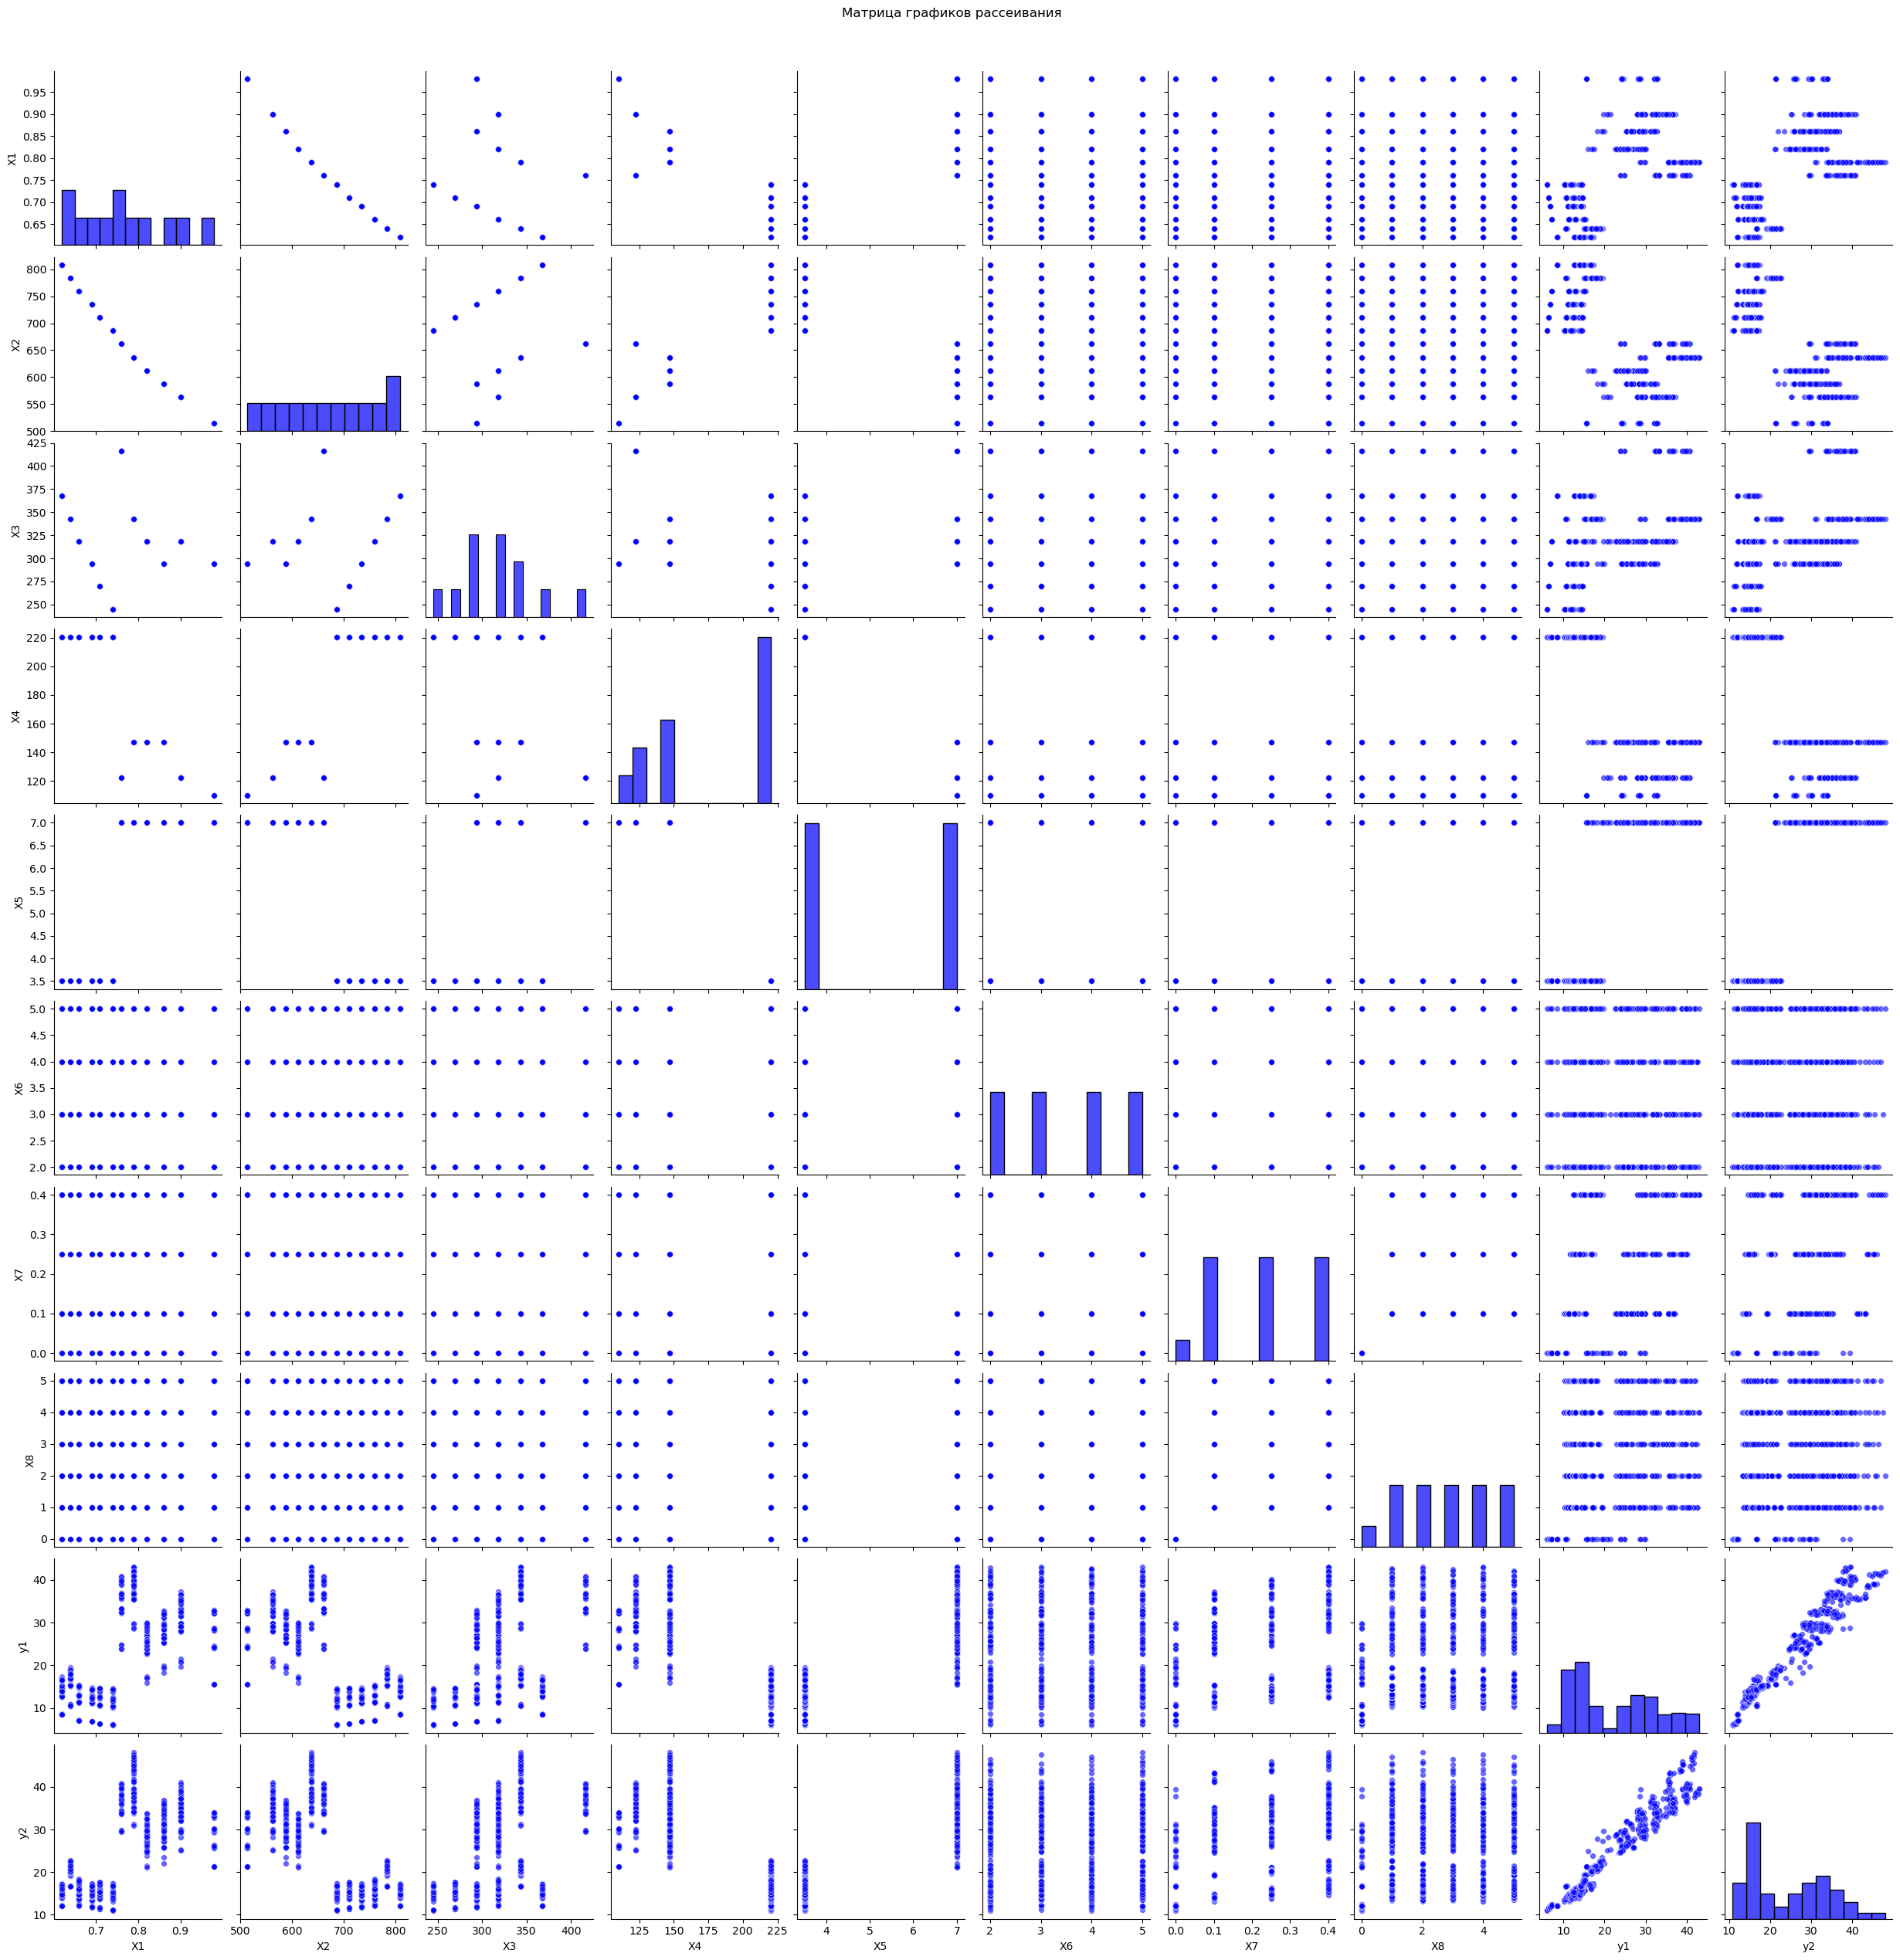

In [19]:
sns.pairplot(data[data.columns], diag_kind='hist', corner=False,
            plot_kws={'alpha': 0.6, 's': 30, 'color': 'blue'},
            diag_kws={'color': 'blue', 'alpha': 0.7})
plt.suptitle('Матрица графиков рассеивания', y=1.02)
plt.show()

АНАЛИЗ РЕЗУЛЬТАТОВ  
В данных нет пропусков и выбросов  
Присутсвует мультиколлинеарность:  
X1 (компактность) очень сильно отрицательно коррелирует с X2 (площадь помещения) (-0.992) - чем меньше площаль помещения, тем больше компактность  
X4 с X5 (-0.973) - чем меньше высота, тем больше площадь крыши (неочевидно)  
y1 с y2 - очень сильная положительная корреляция (0.976). Нагрузка на отопление и охлождение тесно связаны  

Сильные с целевыми переменными:  
X5 с y2: 0.896, X5 с y1: 0.889 - - высота сильно влияет на охлаждение, отопление  
X4 с y1: -0.862, X4 с y2: -0.863 - площадь крыши обратно влияет на охлаждение, отопление  

X6 (ориентация здания), X7 (Площадь остекления), X8 (Распределение площади остекления) не коррелируют практически ни с чем